In [2]:
import numpy as np
import pandas as pd
import joblib
import shap
import xgboost as xgb
from pathlib import Path

# visualization
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

# paths
ART_DIR = Path("artifacts_models")


In [3]:
# Load champion XGB model
bundle = joblib.load(ART_DIR / "model_xgb_base.pkl")

booster = bundle["model"]                  # xgboost.core.Booster
feature_names = bundle["feature_names"]    # IMPORTANT

print("Loaded model type:", type(booster))
print("Number of features:", len(feature_names))

# Load training data used for modeling
data = joblib.load(ART_DIR / "data_final.pkl")
X = data["X_final"][feature_names]
y = data["y"]

print("X shape:", X.shape)
print("Target mean (default rate):", y.mean())


Loaded model type: <class 'xgboost.core.Booster'>
Number of features: 40
X shape: (307511, 40)
Target mean (default rate): 0.08072881945686496


In [4]:
X = data["X_final"][feature_names]


In [5]:
# Convert to DMatrix (XGB native format)
dX = xgb.DMatrix(X, feature_names=feature_names)

# SHAP explainer
explainer = shap.TreeExplainer(booster)

# Compute SHAP values
shap_values = explainer.shap_values(dX)

print("SHAP values shape:", shap_values.shape)


SHAP values shape: (307511, 40)


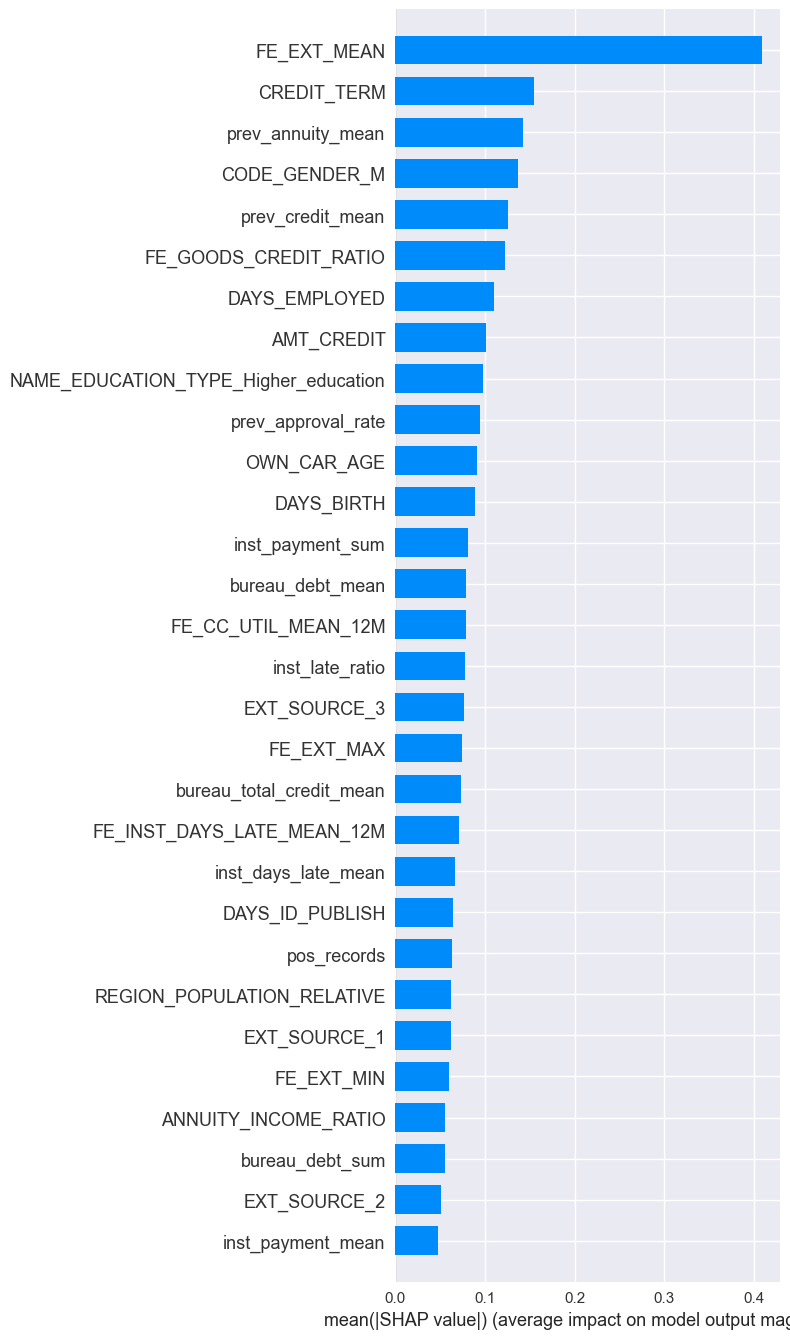

In [6]:
shap.summary_plot(
    shap_values,
    X,
    plot_type="bar",
    max_display=30
)


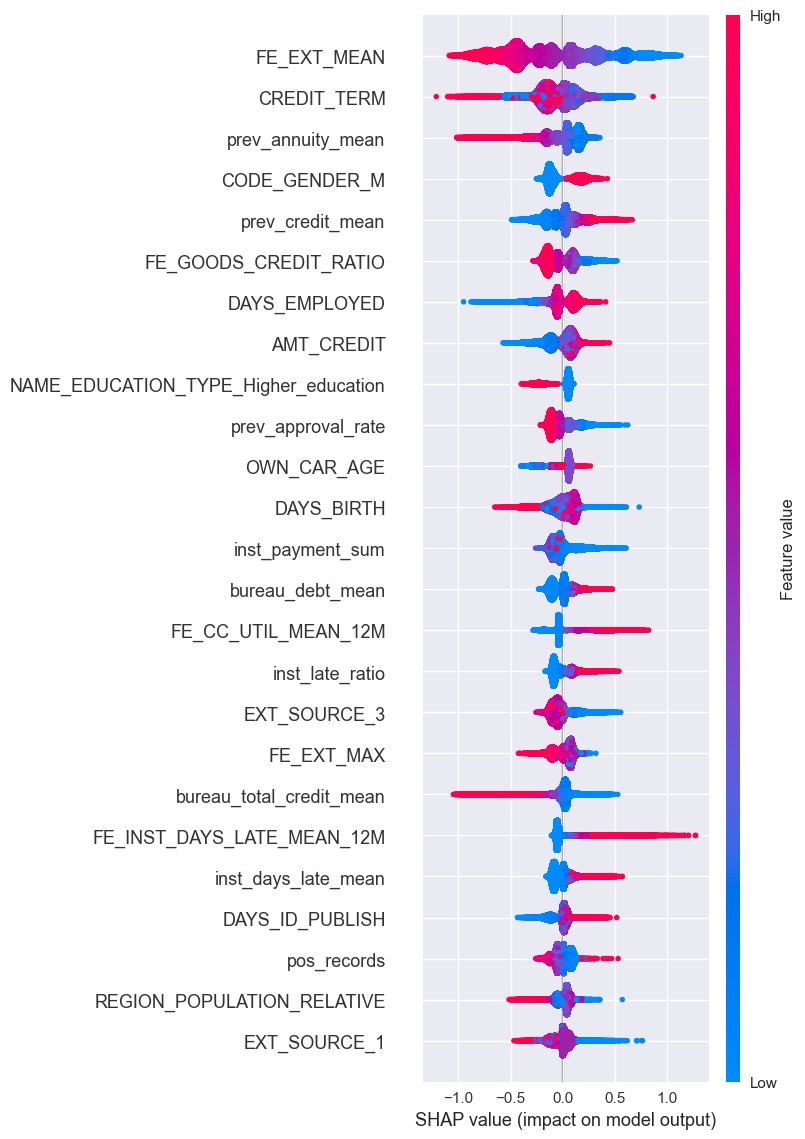

In [7]:
shap.summary_plot(
    shap_values,
    X,
    max_display=25
)


# feature bazlı inceleme

In [8]:
top_feats = pd.Series(
    np.abs(shap_values).mean(axis=0),
    index=feature_names
).sort_values(ascending=False).head(6).index.tolist()

top_feats


['FE_EXT_MEAN',
 'CREDIT_TERM',
 'prev_annuity_mean',
 'CODE_GENDER_M',
 'prev_credit_mean',
 'FE_GOODS_CREDIT_RATIO']

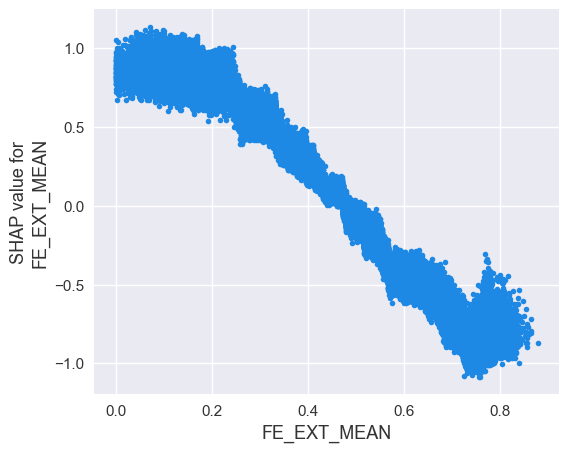

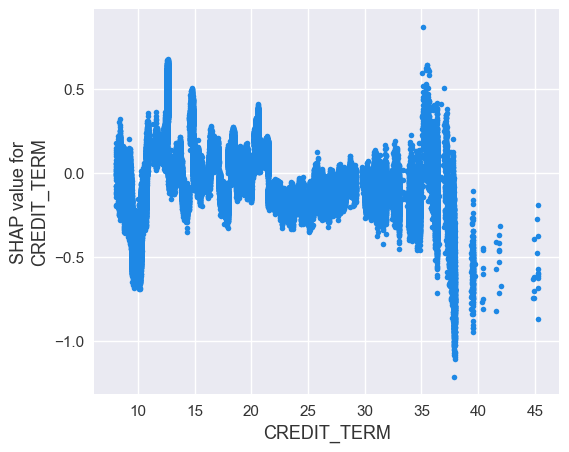

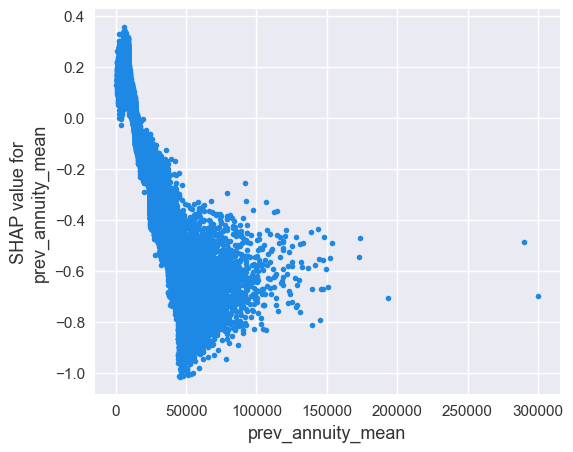

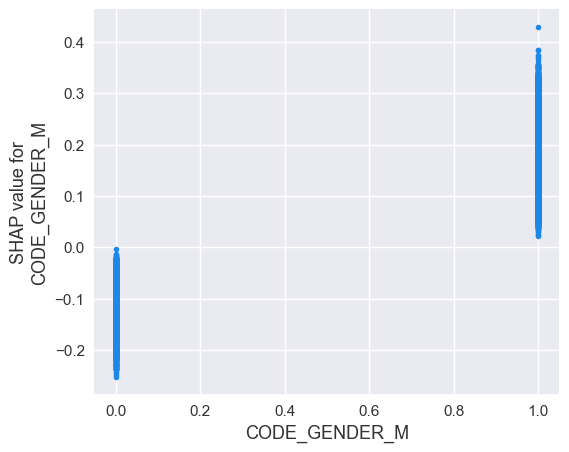

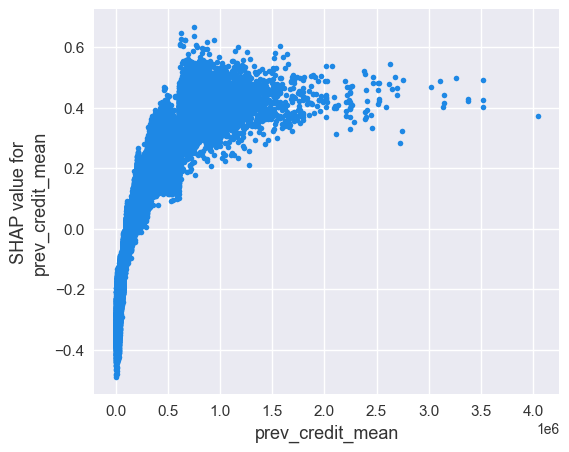

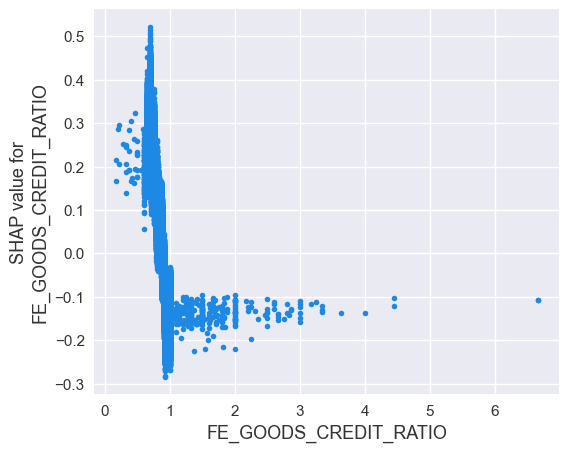

In [9]:
for feat in top_feats:
    shap.dependence_plot(
        feat,
        shap_values,
        X,
        interaction_index=None
    )


# LOCAL EXPLANATION (tek müşteri neden default?)

In [10]:
# pick one high-risk and one low-risk observation
preds = booster.predict(dX)

idx_high = np.argsort(preds)[-1]
idx_low  = np.argsort(preds)[0]

idx_high, preds[idx_high], idx_low, preds[idx_low]


(np.int64(267281),
 np.float32(0.8738078),
 np.int64(260171),
 np.float32(0.0007845837))

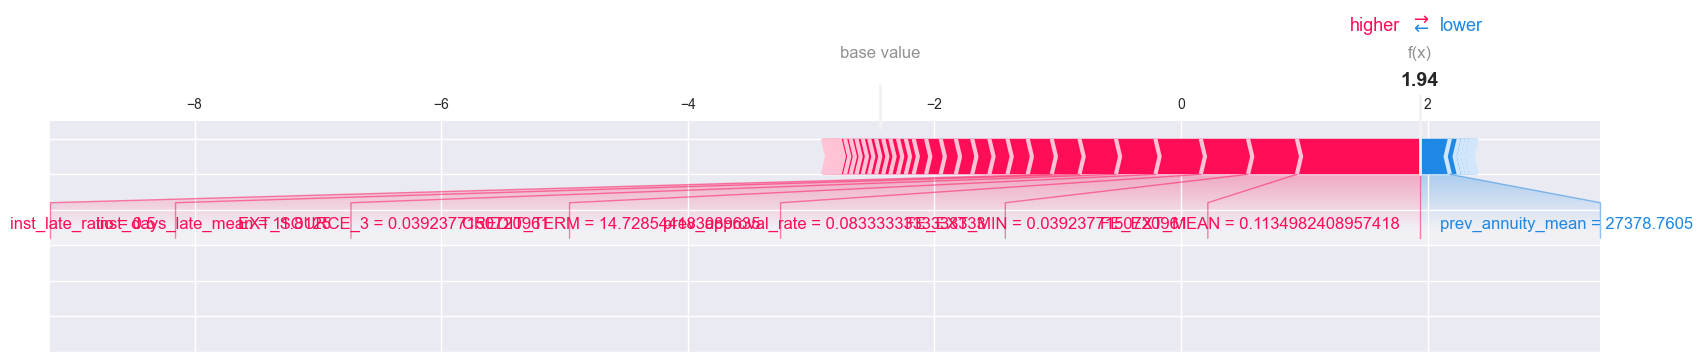

In [11]:
shap.initjs()

shap.force_plot(
    explainer.expected_value,
    shap_values[idx_high],
    X.iloc[idx_high],
    matplotlib=True
)


# Waterfall plot

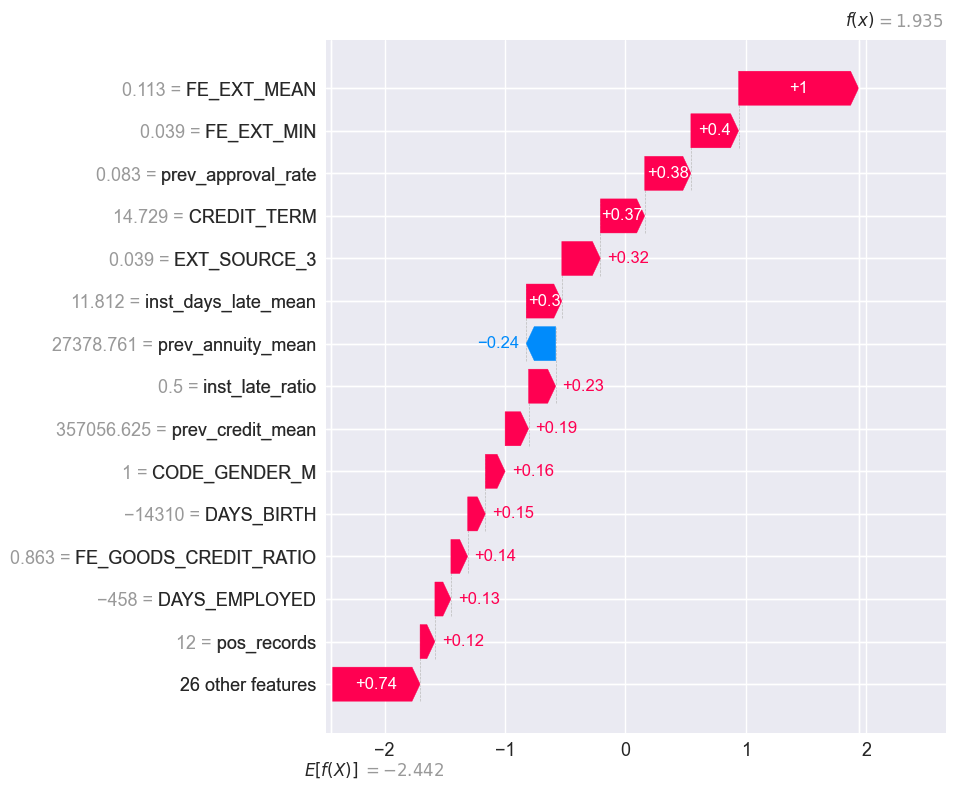

In [13]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[idx_high],
        base_values=explainer.expected_value,
        data=X.iloc[idx_high],
        feature_names=feature_names
    ),
    max_display=15
)


# SHAP Dağılımı, target ilişkisi

In [14]:
shap_df = pd.DataFrame(shap_values, columns=feature_names)
shap_df["TARGET"] = y.values

shap_df.groupby("TARGET")[top_feats].mean()


,FE_EXT_MEAN,CREDIT_TERM,prev_annuity_mean,CODE_GENDER_M,prev_credit_mean,FE_GOODS_CREDIT_RATIO
TARGET,,,,,,
0,-0.154864,-0.056595,-0.016179,-0.020403,0.004303,-0.021210
1,0.228988,0.057227,0.014080,0.013155,0.004181,0.022841


In [15]:
print(shap_df.groupby("TARGET")[top_feats].mean())

        FE_EXT_MEAN  CREDIT_TERM  prev_annuity_mean  CODE_GENDER_M  \
TARGET                                                               
0         -0.154864    -0.056595          -0.016179      -0.020403   
1          0.228988     0.057227           0.014080       0.013155   

        prev_credit_mean  FE_GOODS_CREDIT_RATIO  
TARGET                                           
0               0.004303              -0.021210  
1               0.004181               0.022841  


# Model Interpretation and Explainability Results (SHAP Analysis)

In this study, the **champion credit default prediction model**, based on **XGBoost**, was analyzed using **SHAP (Shapley Additive Explanations)** to provide both **global** and **local** interpretability. The goal of this analysis is not only to achieve strong predictive performance, but also to clearly explain *why* the model makes certain decisions, which is critical for credit risk, regulatory compliance, and business trust.

---

## 1. Global Model Behavior: What Does the Model Focus On?

The SHAP summary (beeswarm) plot and mean absolute SHAP values show that the model’s decision-making process is primarily driven by the following groups of features:

- **External credit score features**
  - `FE_EXT_MEAN`, `EXT_SOURCE_3`, `FE_EXT_MIN`, `FE_EXT_MAX`
- **Credit maturity and credit burden**
  - `CREDIT_TERM`, `FE_GOODS_CREDIT_RATIO`
- **Payment behavior and delinquency**
  - `inst_days_late_mean`, `inst_late_ratio`, `FE_INST_DAYS_LATE_MEAN_12M`
- **Demographic and employment characteristics**
  - `DAYS_BIRTH`, `DAYS_EMPLOYED`, `CODE_GENDER_M`
- **Historical credit and application behavior**
  - `prev_approval_rate`, `prev_annuity_mean`, `prev_credit_mean`

This structure indicates that the model behaves in line with established credit risk intuition:

> Rather than relying on a single variable, the model evaluates **creditworthiness as a combination of credit history, repayment discipline, and borrowing capacity**.

---

## 2. Direction of Effects: When Does Risk Increase or Decrease?

The SHAP beeswarm plot provides insight not only into feature importance, but also into **how feature values influence default risk**.

### External Credit Scores (EXT_SOURCE family)
- **High values (red points)** are associated with **negative SHAP values**, meaning they **reduce default risk**
- **Low values (blue points)** are associated with **positive SHAP values**, meaning they **increase default risk**

This confirms that external credit scores act as strong *risk-mitigating* signals in the model.

---

### Credit Term (`CREDIT_TERM`)
- Longer loan maturities consistently push SHAP values in the **positive direction**
- Shorter maturities tend to reduce predicted risk

This aligns with classical credit risk principles: longer-term loans carry higher uncertainty and repayment risk.

---

### Payment Delinquency Indicators
- Even moderate increases in delinquency metrics lead to **positive SHAP contributions**
- The model treats payment delays as highly informative early warning signals

In practice, this reflects the principle that **past repayment behavior is one of the strongest predictors of future default**.

---

## 3. Local Explanations: Why Is a Specific Customer Considered High Risk?

The SHAP waterfall (force) plot illustrates how the model arrives at a prediction for an individual customer.

For the analyzed high-risk customer:

- The model starts from a **baseline expectation** representing the average borrower
- The following factors push the prediction toward higher default risk:
  - Low `FE_EXT_MEAN` and `FE_EXT_MIN`
  - Low historical approval rate (`prev_approval_rate`)
  - Long `CREDIT_TERM`
  - Elevated installment delinquency metrics
- The cumulative effect of these signals results in a high model output  
  (e.g., *f(x) ≈ 1.94*, corresponding to a high default probability)

Importantly:

> The customer is not classified as risky due to a single extreme variable, but rather due to **the combined effect of multiple moderate risk factors**.

This demonstrates that the model’s decisions are **multidimensional and consistent**, rather than arbitrary.

---

## 4. Default vs. Non-Default Comparison (Class-Level SHAP Averages)

A comparison of mean SHAP values across default (`TARGET = 1`) and non-default (`TARGET = 0`) groups further clarifies how the model separates the two populations:

| Feature | Non-Default (TARGET=0) | Default (TARGET=1) | Interpretation |
|-------|----------------|----------------|----------------|
| FE_EXT_MEAN | Negative | Positive | Lower external scores increase risk |
| CREDIT_TERM | Negative | Positive | Longer maturities increase risk |
| prev_annuity_mean | Lower | Higher | Heavier payment burden |
| CODE_GENDER_M | Slightly negative | Slightly positive | Weak but consistent demographic signal |
| FE_GOODS_CREDIT_RATIO | Negative | Positive | Higher credit burden increases risk |

Although individual differences may appear small in isolation, tree-based models aggregate these signals **non-linearly**, leading to strong overall discrimination.

---

## 5. Business-Oriented Summary

From a business and risk management perspective, this model:

- Produces **highly interpretable credit risk predictions**
- Bases decisions on:
  - Repayment behavior
  - Credit history
  - Debt burden
  - External creditworthiness indicators
- Avoids reliance on a single dominant variable
- Provides:
  - **Portfolio-level insights** for policy design
  - **Customer-level explanations** for decision transparency

As a result, the model is well-suited for use in:

- Credit committee decision processes
- Regulatory and audit contexts
- Customer-facing explanation and dispute resolution workflows

Overall, the SHAP analysis confirms that the model delivers **transparent, defensible, and economically meaningful credit risk assessments**.
